# Group 25 DSCI Project (DSCI 009)
##### Members: Tianchen Wei, Dinh Nam Khanh Le, Alan Wei, Jacky Lin (non-contributing)

## Introduction

The general topic we have decided to focus on is heart disease, and the ability to predict its presence based on symptoms/measurements we have observed. One subarea of focus for heart disease is around coronary artery disease. To determine whether a patient has this disease, coronary angiograms are conducted. By releasing a dye into the arteries (which makes the arteries visible) and using an X-ray, we can look at blood vessels in the heart, and thus determine if they are narrowed. 

In our project, we will use a dataset from the article “International application of a new probability algorithm for the diagnosis of coronary artery disease” (Detrano et al, 1989) to train a model estimating probabilities of coronary disease. The research considers variables including, but not limited to, resting blood pressure, maximum heart rate reached, and chest pain type. The diagnosis is binary, with the possible diagnoses being “normal” and “abnormal”. In our dataset, a diameter narrowing of 50% or greater is considered abnormal. Using this dataset, we will try to answer this question: 

What set/combination of variable values will best determine/predict that a person will most likely have a heart disease?


## Methods and Results

First, we will start off with installing packages, libraries, and introducing the dataset.

In [ ]:
# install.packages("kknn")
# install.packages("themis")

In [2]:
library(repr)
library(tidyverse)
library(tidymodels)
library(ggplot2)
library(RColorBrewer)
library(kknn)
library(themis)
set.seed(3456)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

#### Variables:

`age`: age in years

`sex`: sex (1 = male; 0 = female)

`cp`: chest pain type
        -- Value 1: typical angina
        -- Value 2: atypical angina
        -- Value 3: non-anginal pain
        -- Value 4: asymptomatic

`trestbps`: resting blood pressure (in mm Hg on admission to the hospital)

`chol`: serum cholestoral in mg/dl

`fbs`: (fasting blood sugar > 120 mg/dl)  (1 = true; 0 = false)

`restecg`: resting electrocardiographic results
        -- Value 0: normal
        -- Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
        -- Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria

`thalach`: maximum heart rate achieved

`exang`: exercise induced angina (1 = yes; 0 = no)

`oldpeak` = ST depression induced by exercise relative to rest

`slope`: the slope of the peak exercise ST segment -- Value 1: upsloping -- Value 2: flat -- Value 3: downsloping

`ca`: number of major vessels (0-3) colored by flourosopy

`thal`: 3 = normal; 6 = fixed defect; 7 = reversable defect

`num`: diagnosis of heart disease (angiographic disease status) -- Value 0: < 50% diameter narrowing (Normal)-- Value 1: > 50% diameter narrowing (Abnormal)

### Dataset:

In [3]:
#Demonstration that the dataset can be read from the web into R and cleaning and wrangling our data into a tidy format.
H_D_cleveland <- read_csv("https://raw.githubusercontent.com/TimWei12/Group_25_project/main/processed.cleveland.data",
                          col_names=c("age", "sex", "cp","trestbps", "chol", "fbs", "restecg","thalach", "exang", "oldpeak", "slope", "ca", "thal", "num")) |>
    filter(ca != "?" & thal != "?") |>
    filter(num == 1 | num == 0) |>
    mutate(num = as.factor(num), ca = as.double(ca), thal = as.double(thal)) |>
    mutate(num = fct_recode(num, "Normal" = "0", "Abnormal" = "1"))
H_D_cleveland
# , ca = as.double(ca), thal = as.double(thal)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): ca, thal
dbl (12): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0,6,Normal
67,1,4,120,229,0,2,129,1,2.6,2,2,7,Abnormal
37,1,3,130,250,0,0,187,0,3.5,3,0,3,Normal
41,0,2,130,204,0,2,172,0,1.4,1,0,3,Normal
56,1,2,120,236,0,0,178,0,0.8,1,0,3,Normal
57,0,4,120,354,0,0,163,1,0.6,1,0,3,Normal
53,1,4,140,203,1,2,155,1,3.1,3,0,7,Abnormal
57,1,4,140,192,0,0,148,0,0.4,2,0,6,Normal
56,0,2,140,294,0,2,153,0,1.3,2,0,3,Normal


#### Summary of Dataset

In [54]:
#Finding max value of each column
cleveland_max <- H_D_cleveland |>
    select(-num) |>
    map_dfc(max, na.rm =TRUE)
     

#Finding mean value of each column
cleveland_mean <- H_D_cleveland |>
    select(-num) |>
    map_dfc(mean, na.rm =TRUE)
     

#Finding min value of each column
cleveland_min <- H_D_cleveland |>
    select(-num) |>
    map_dfc(min, na.rm =TRUE)
     
#Merging tables into one
cleveland_sum <- bind_rows(cleveland_max, cleveland_min, cleveland_mean) |>
    add_column(summary = c("max", "min", "mean"), .before= "age")
cleveland_sum

#Summary table for additional information
summary(cleveland_train)

summary,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
max,76.00000,1.0000000,4.000000,192.0000,564.0000,1.0000000,2.0000000,202.0000,1.0000000,4.2000000,3.00000,3.0000000,7.000000
min,29.00000,0.0000000,1.000000,94.0000,126.0000,0.0000000,0.0000000,88.0000,0.0000000,0.0000000,1.00000,0.0000000,3.000000
mean,53.39252,0.6261682,2.929907,130.2103,244.9206,0.1214953,0.9205607,155.4019,0.2196262,0.7056075,1.46729,0.3925234,4.172897


      age             sex               cp           trestbps    
 Min.   :29.00   Min.   :0.0000   Min.   :1.000   Min.   : 94.0  
 1st Qu.:46.00   1st Qu.:0.0000   1st Qu.:2.000   1st Qu.:120.0  
 Median :54.00   Median :1.0000   Median :3.000   Median :130.0  
 Mean   :52.99   Mean   :0.6375   Mean   :2.894   Mean   :129.6  
 3rd Qu.:59.00   3rd Qu.:1.0000   3rd Qu.:4.000   3rd Qu.:140.0  
 Max.   :71.00   Max.   :1.0000   Max.   :4.000   Max.   :192.0  
      chol            fbs           restecg          thalach     
 Min.   :126.0   Min.   :0.000   Min.   :0.0000   Min.   : 88.0  
 1st Qu.:206.5   1st Qu.:0.000   1st Qu.:0.0000   1st Qu.:146.8  
 Median :234.0   Median :0.000   Median :0.0000   Median :159.5  
 Mean   :242.0   Mean   :0.125   Mean   :0.8875   Mean   :156.6  
 3rd Qu.:267.2   3rd Qu.:0.000   3rd Qu.:2.0000   3rd Qu.:170.0  
 Max.   :564.0   Max.   :1.000   Max.   :2.0000   Max.   :202.0  
     exang           oldpeak           slope             ca        
 Min.   

These numbers give us some insight as to the range that the variables can exist in, and help us look out for mistakes by referencing these values.

Next, we can take a look at how the variables we will use for our models relate to our response variable:

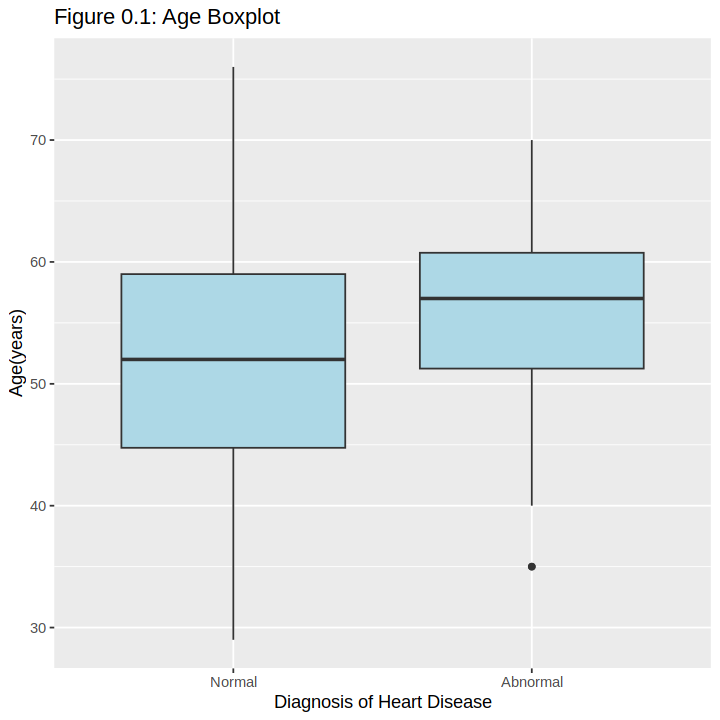

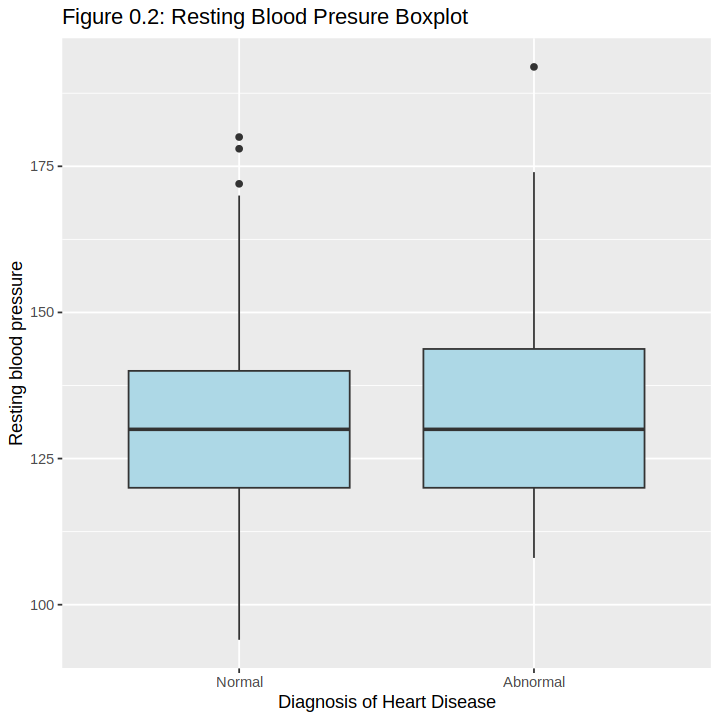

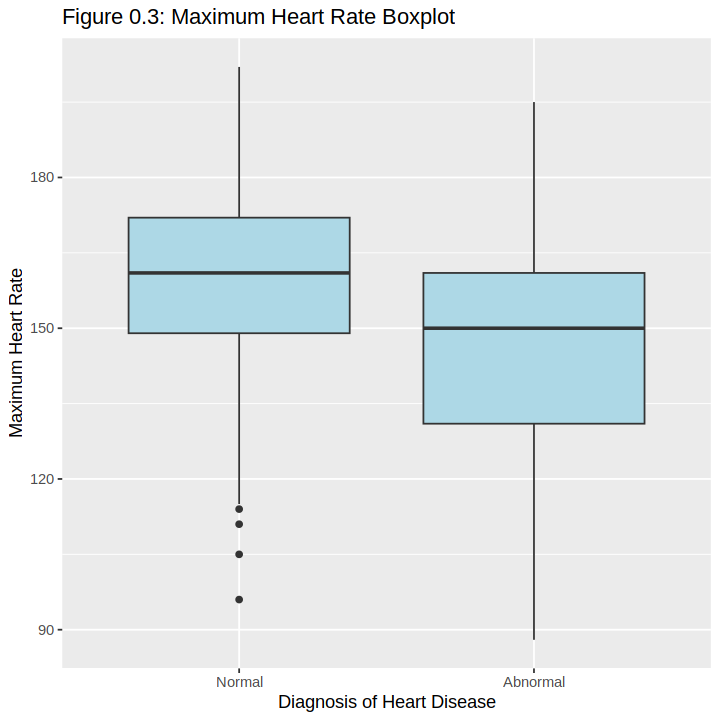

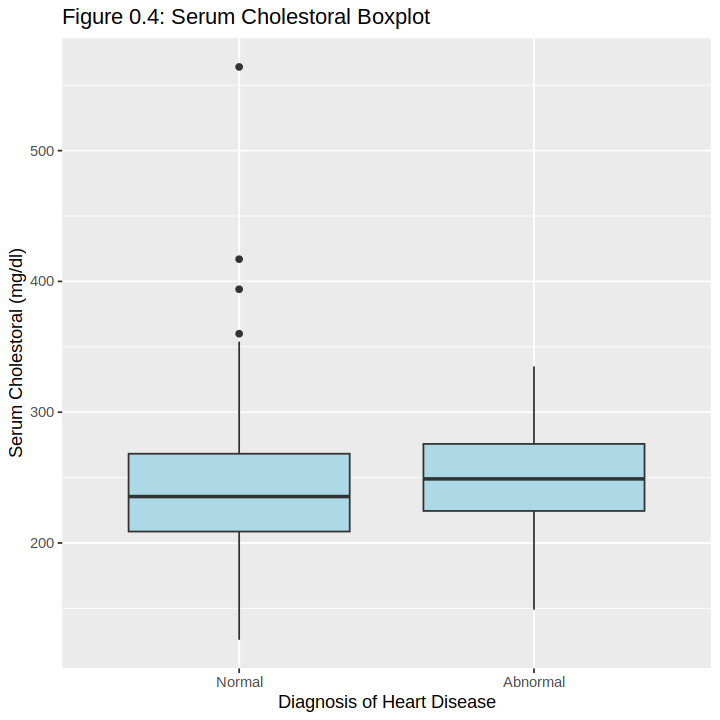

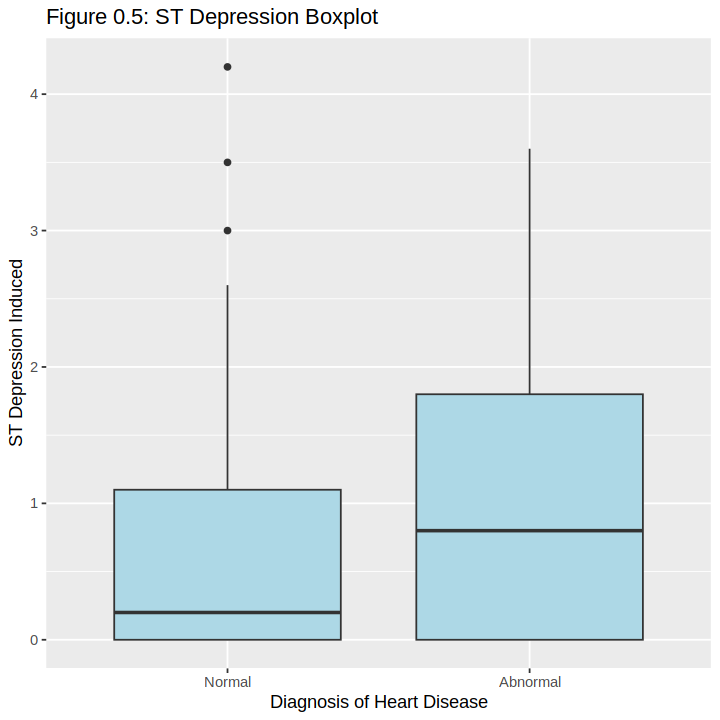

In [56]:
options (repr.plot.width = 6, repr.plot.height = 6)
#Plot varaiables vs. predictor using box plot
box_plot_age <- H_D_cleveland |> 
    ggplot(aes(x=num, y=age)) +
    geom_boxplot(fill="lightblue") + 
    labs(x= "Diagnosis of Heart Disease", y= "Age(years)") +
    ggtitle("Figure 0.1: Age Boxplot") 

box_plot_restbps <- H_D_cleveland |> 
    ggplot(aes(x=num, y=trestbps))+
    geom_boxplot(fill="lightblue") + 
    labs(x= "Diagnosis of Heart Disease", y= "Resting blood pressure") +
    ggtitle("Figure 0.2: Resting Blood Presure Boxplot")  

box_plot_thalach <- H_D_cleveland |> 
    ggplot(aes(x=num, y=thalach))+
    geom_boxplot(fill="lightblue") + 
    labs(x= "Diagnosis of Heart Disease", y= "Maximum Heart Rate") +
    ggtitle("Figure 0.3: Maximum Heart Rate Boxplot")  

box_plot_chol <- H_D_cleveland |> 
    ggplot(aes(x=num, y=chol))+
    geom_boxplot(fill="lightblue") + 
    labs(x= "Diagnosis of Heart Disease", y= "Serum Cholestoral (mg/dl)") +
    ggtitle("Figure 0.4: Serum Cholestoral Boxplot")  

box_plot_oldpeak <- H_D_cleveland |> 
    ggplot(aes(x=num, y=oldpeak))+
    geom_boxplot(fill="lightblue") + 
    labs(x= "Diagnosis of Heart Disease", y= "ST Depression Induced") +
    ggtitle("Figure 0.5: ST Depression Boxplot") 

box_plot_age
box_plot_restbps
box_plot_thalach
box_plot_chol
box_plot_oldpeak

The box plots are used to compare the range (min, max, mean) of the variables, which is split by our response variable (i.e. normal or abnormal). The graphs help to initially visualize which variables make a larger impact in the final diagnosis (i.e. response variable result).

Now, we can move on to splitting up our data for training and testing, as well us creating our models:

In [4]:
#split the dataset into the training dataset and testing dataset
# Randomly take 75% of the data in the training set
set.seed(4567)
cleveland_split <- initial_split(H_D_cleveland, prop = 0.75, strata = num)  
cleveland_train <- training(cleveland_split)   
cleveland_test <- testing(cleveland_split)

### Model 1: Age, Resting blood sugar, Cholesterol, Maximum heart rate, ST depression

In [5]:
#Set recipe for building Model.1---all the numerical variables
knn_recipe <- recipe(num ~ age+trestbps+chol+thalach+oldpeak, data=cleveland_train) 
                    
#Set recipe to balance the number of Abnormal and Normal
knn_recipe_balance <- recipe(num ~ age+trestbps+chol+thalach+oldpeak, data=cleveland_train) |>
                    step_upsample(num, over_ratio=1, skip=FALSE) |>
                    prep()

In [6]:
#Check if we have same number of Normal and Abnormal
cleveland_train_new <- bake(knn_recipe_balance, cleveland_train)
cleveland_train_new |>
group_by(num) |>
summarise(n=n())

num,n
<fct>,<int>
Normal,120
Abnormal,120


*Table 1: Balanced response variable*

In [7]:
#Build Model.1 with all the numerical variables
set.seed(9999)
#Build a model to find the best K of Model.1 
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
            set_engine("kknn") |>
            set_mode("classification")

# knn_recipe <- recipe(num ~ ., data = cleveland_train_scaled)

k_vfold <- vfold_cv(cleveland_train_new, v=5, strata = num)
k_val <- tibble(neighbors = seq(from=1, to=20))

#Fit the model to find the best K
knn_fit <- workflow() |>
         add_recipe(knn_recipe) |>
         add_model(knn_spec) |>
        tune_grid(resamples = k_vfold, grid = k_val)


In [8]:
#Creat a dataframe of K value
k_best <- knn_fit |>
        collect_metrics() |>
        filter(.metric == "accuracy") 

        # arrange(mean) |>
        # select(neighbors) |>
        # tail(1) |>
        # pull()

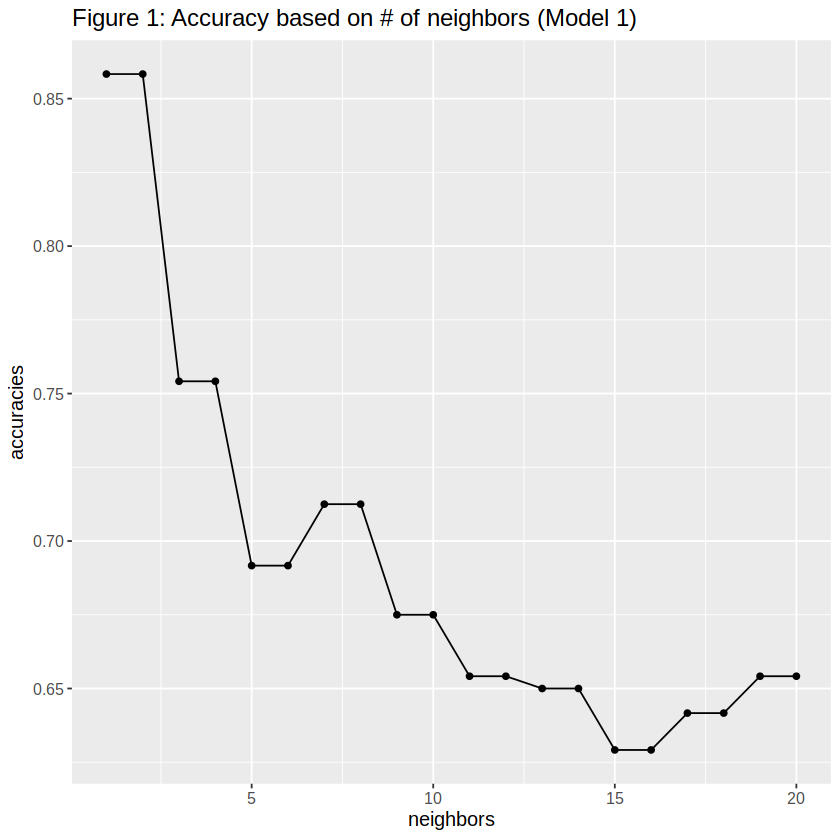

In [25]:
#Creat a scatter plot with a line to select best K value
k_best_plot_1 <- k_best |>
                ggplot(aes(x=neighbors, y=mean))+
                       geom_point()+
                        geom_line()+
                        labs(x="neighbors", y="accuracies")+
                        theme(text=element_text(size=12)) +
                        xlim(c(1, 20)) +
                        ggtitle("Figure 1: Accuracy based on # of neighbors (Model 1)")
k_best_plot_1

from the scatter plot we can see the best value might be 1 or 2, so, we pick k = 2 since increase or decrease in a small amount the accuracy would change much. 

In [26]:
#Build Model.1 using best K
knn_spec_bestK_all <- nearest_neighbor(weight_func = "rectangular", neighbors = 2) |>
            set_engine("kknn") |>
            set_mode("classification")

knn_fit_bestK_all <- workflow() |>
        add_recipe(knn_recipe) |>
        add_model(knn_spec_bestK_all) |>
        fit(data=cleveland_train_new)

#Predict the and bind to the test data
prediction_all <- predict(knn_fit_bestK_all, cleveland_test) |>
                bind_cols(cleveland_test)

#Check the accuracy and confusion
accuracy_all <- prediction_all |> metrics(truth=num, estimate=.pred_class) |>
                filter(.metric == "accuracy")
accuracy_all

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7777778


*Table 2: Accuracy of Model 1*

In [28]:
confusion_all <- prediction_all |>
                conf_mat(truth=num, estimate=.pred_class)
confusion_all

          Truth
Prediction Normal Abnormal
  Normal       34        6
  Abnormal      6        8

*Table 3: Confusion Matrix for Model 1*

## Model 2: Resting blood sugar, cholesterol

First, we can take a look at the relationship between the 2 variables, to get an intial understanding to whether it will make an impact on our model.

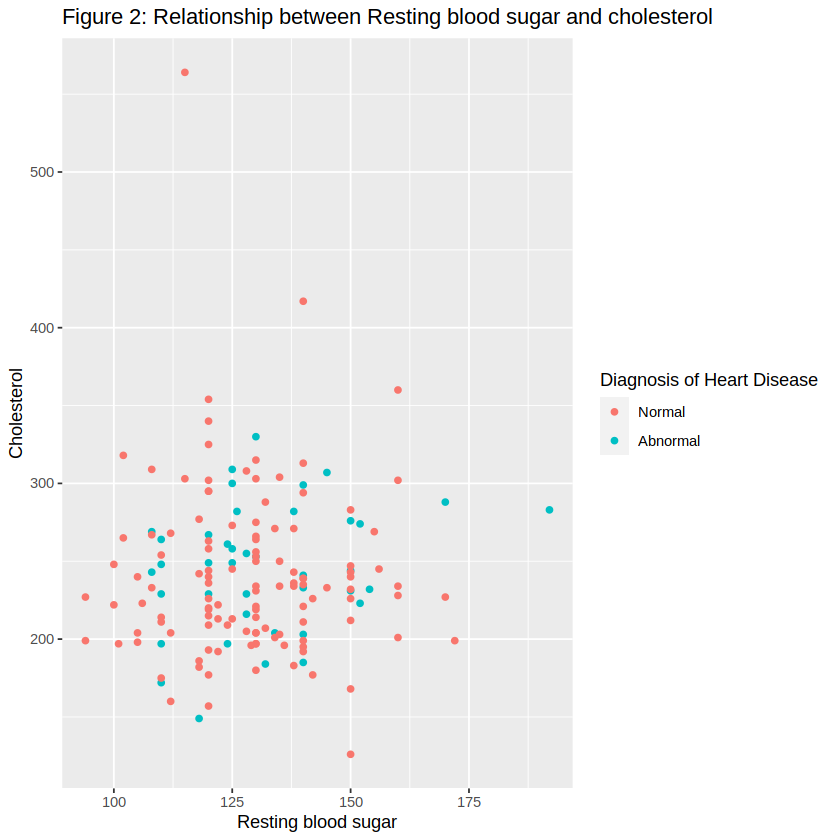

In [41]:
#Visualize relationship between resting blood sugar, cholesterol, and diagnosis
Model.2_plot<- cleveland_train |>
    ggplot(aes(x=trestbps, y=chol, color=num)) +
    geom_point() +
    labs(x = "Resting blood sugar", y = "Cholesterol", color = "Diagnosis of Heart Disease") +
    scale_fill_distiller(palette="Spectral") + 
    ggtitle("Figure 2: Relationship between Resting blood sugar and cholesterol")
Model.2_plot

We see that there is no relationship, so we can already guess that they may not be a strong combination in predicting the correct result.

In [11]:
#Build a balanced recipe for Model.2
knn_recipe_balance2 <- recipe(num ~ trestbps+chol, data=cleveland_train) |>
                    step_upsample(num, over_ratio=1, skip=FALSE) |>
                    prep()

#Check whether numbers of Normal and Abnormal are same
cleveland_train_new2 <- bake(knn_recipe_balance, cleveland_train)
cleveland_train_new2 |>
group_by(num) |>
summarise(n=n())

num,n
<fct>,<int>
Normal,120
Abnormal,120


*Table 1: Balanced response variable (Repeated for Clarity)*

In [29]:
set.seed(9999)
#Build recipe_two for Model.2 with two variable (trestbps + chol)
knn_recipe_two <- recipe(num ~ trestbps+chol, data = cleveland_train_new2) 
                    # step_scale(all_predictors()) |>
                    # step_center(all_predictors())

#Build a model to find best K for Model.2
knn_fit_two <- workflow() |>
         add_recipe(knn_recipe_two) |>
         add_model(knn_spec) |>
        tune_grid(resamples = k_vfold, grid = k_val)

In [30]:
#Fit the model to make a dataframe of K
k_best_two <- knn_fit_two |>
        collect_metrics() |>
        filter(.metric == "accuracy") 

        #  arrange(mean) |>
        # select(neighbors) |>
        # tail(1) |>
        # pull()

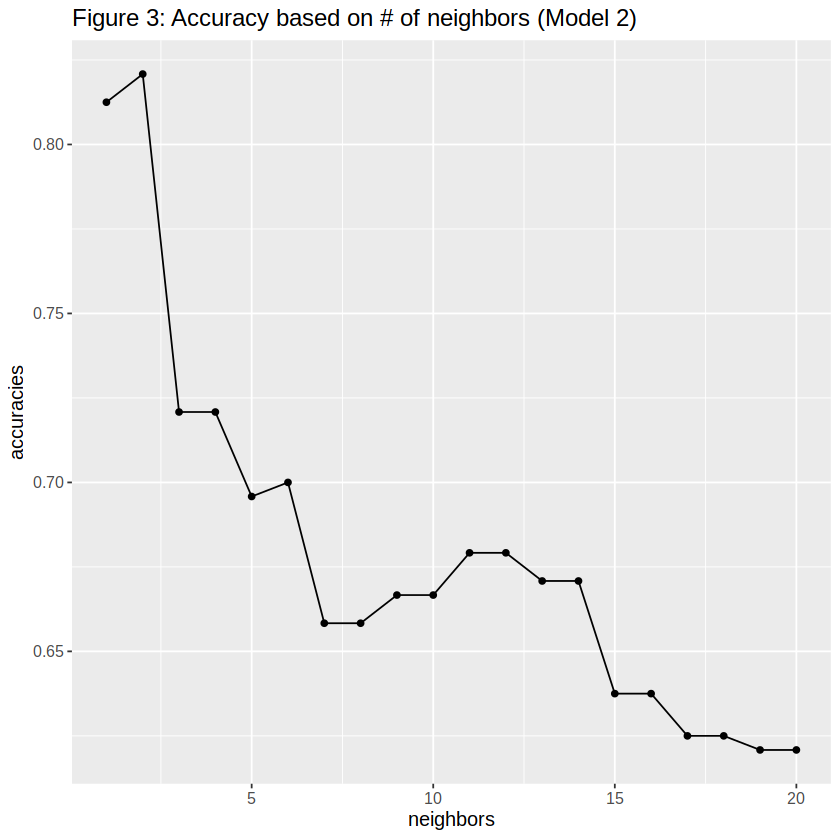

In [50]:
#Visualization of K to select the best K
k_best_plot_2 <- k_best_two |>
                ggplot(aes(x=neighbors, y=mean))+
                       geom_point()+
                        geom_line()+
                        labs(x="neighbors", y="accuracies")+
                        theme(text=element_text(size=12)) +
                        xlim(c(1, 20)) +
                        ggtitle("Figure 3: Accuracy based on # of neighbors (Model 2)")
k_best_plot_2

In [32]:
#Build the Model.2 with two variables using best K = 2
knn_spec_bestK_two <- nearest_neighbor(weight_func = "rectangular", neighbors = 2) |>
            set_engine("kknn") |>
            set_mode("classification")

#Fit the Model.2
knn_fit_bestK_two <- workflow() |>
        add_recipe(knn_recipe_two) |>
        add_model(knn_spec_bestK_two) |>
        fit(data=cleveland_train_new2)

#Predict and bind to the test data
prediction_two <- predict(knn_fit_bestK_two, cleveland_test) |>
                bind_cols(cleveland_test)

#Check the accuracy and confusion of Model.2
accuracy_two <- prediction_two |> metrics(truth=num, estimate=.pred_class) |>
                filter(.metric == "accuracy")
accuracy_two

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.5740741


*Table 4: Accuracy for Model 2*

In [33]:
confusion_two <- prediction_two |>
                conf_mat(truth=num, estimate=.pred_class)
confusion_two

          Truth
Prediction Normal Abnormal
  Normal       27       10
  Abnormal     13        4

*Table 5: Confusion Matrix for Model 2*

## Model 3: Maximum heart rate, age

Again, we can take an intial look at the relationship between the 2 variables.

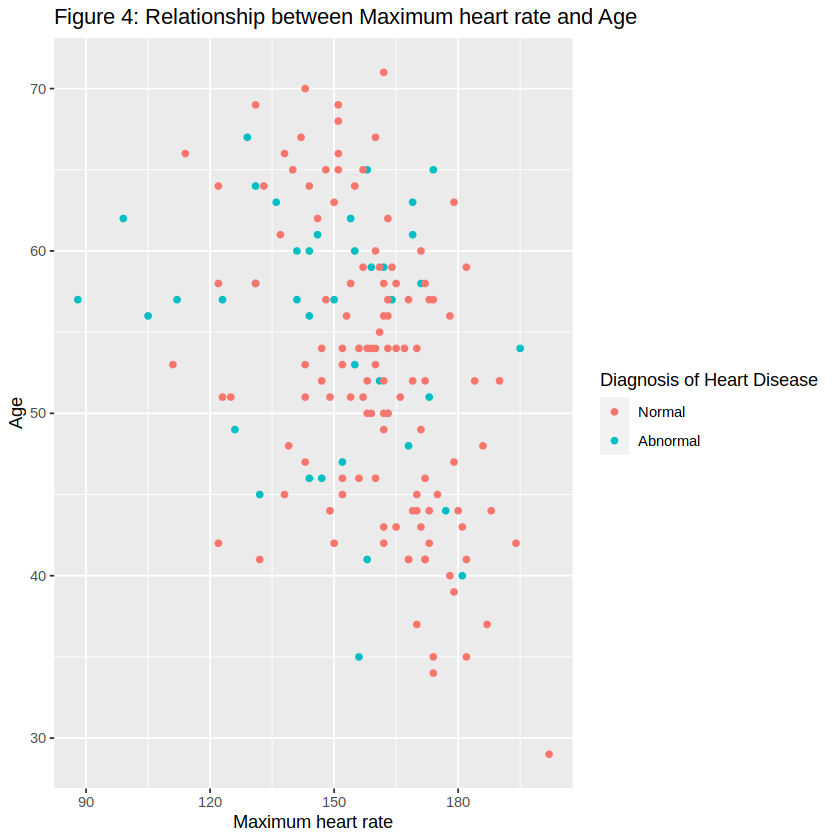

In [49]:
Model.3_plot<- cleveland_train |>
    ggplot(aes(x=thalach, y=age, color=num)) +
    geom_point() +
    labs(x = "Maximum heart rate", y = "Age", color = "Diagnosis of Heart Disease") +
    scale_fill_distiller(palette="Spectral") + 
    ggtitle("Figure 4: Relationship between Maximum heart rate and Age")
Model.3_plot

As with figure 2, there is not strong relationship, and thus will most likely not produce a strong result in finding predictions.

In [43]:
#Build a recipe to balance the number of Normal and Abnormal
knn_recipe_balance3 <- recipe(num ~ thalach+age, data=cleveland_train) |>
                    step_upsample(num, over_ratio=1, skip=FALSE) |>
                    prep()

#Check whether the data is balanced
cleveland_train_new3 <- bake(knn_recipe_balance3, cleveland_train)
cleveland_train_new3 |>
group_by(num) |>
summarise(n=n())

num,n
<fct>,<int>
Normal,120
Abnormal,120


*Table 1: Balanced response variable (Repeated for Clarity)*

In [44]:
set.seed(9999)

#Build a recipe for Model.3 with two variables --- thalach+age
knn_recipe_two2 <- recipe(num ~ thalach+age, data = cleveland_train_new3) |>
                    step_scale(all_predictors()) |>
                    step_center(all_predictors())

#Build the workflow to find the best K
knn_fit_two2 <- workflow() |>
         add_recipe(knn_recipe_two2) |>
         add_model(knn_spec) |>
        tune_grid(resamples = k_vfold, grid = k_val)

In [45]:
#Fit the model to find the best K
k_best_two2 <- knn_fit_two2 |>
        collect_metrics() |>
        filter(.metric == "accuracy") 

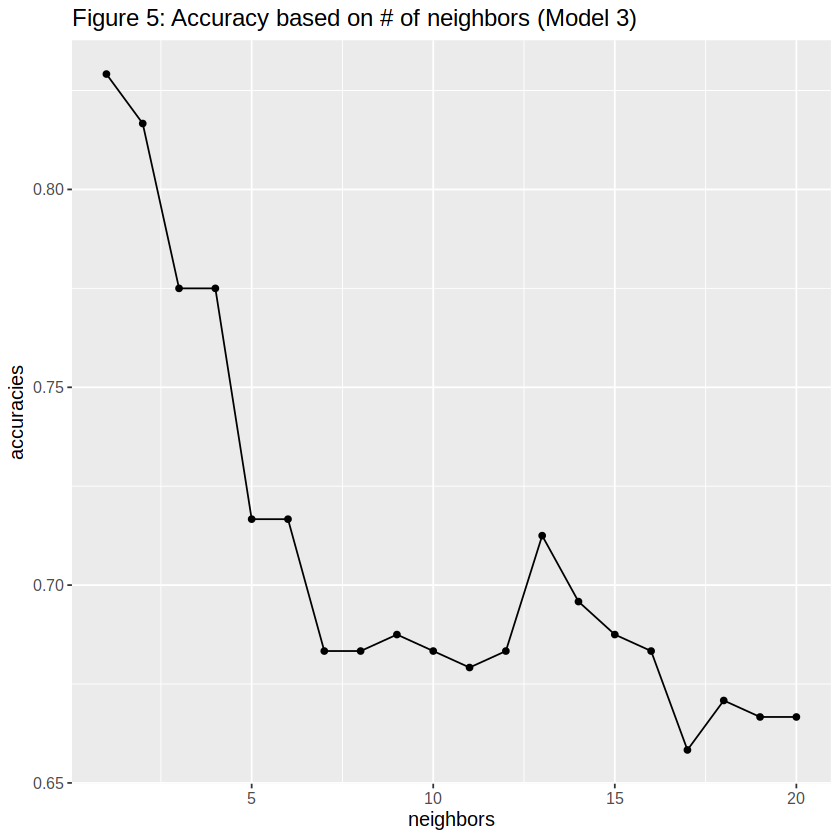

In [51]:
#PLot the accuracy of K to select the best K
k_best_plot_3 <- k_best_two2 |>
                ggplot(aes(x=neighbors, y=mean))+
                       geom_point()+
                        geom_line()+
                        labs(x="neighbors", y="accuracies")+
                        theme(text=element_text(size=12)) +
                        xlim(c(1, 20)) +
                        ggtitle("Figure 5: Accuracy based on # of neighbors (Model 3)")
k_best_plot_3

In [47]:
#Build the Model.3 with two variables using Best K = 2
knn_spec_bestK_two2 <- nearest_neighbor(weight_func = "rectangular", neighbors = 2) |>
            set_engine("kknn") |>
            set_mode("classification")

#Build the workflow of Model.3 and fit to the balanced training data
knn_fit_bestK_two2 <- workflow() |>
        add_recipe(knn_recipe_two2) |>
        add_model(knn_spec_bestK_two2) |>
        fit(data=cleveland_train_new3)

#Predict using Model.3 and bind to the test data
prediction_two2 <- predict(knn_fit_bestK_two2, cleveland_test) |>
                bind_cols(cleveland_test)

#Find the accuracy and confusion of Model.3
accuracy_two2 <- prediction_two2 |> metrics(truth=num, estimate=.pred_class) |>
                filter(.metric == "accuracy")
accuracy_two2

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6481481


*Table 6: Accuracy for Model 3*

In [48]:
confusion_two2 <- prediction_two2 |>
                conf_mat(truth=num, estimate=.pred_class)
confusion_two2

          Truth
Prediction Normal Abnormal
  Normal       30        9
  Abnormal     10        5

*Table 7: Confusion Matrix for Model 3*

# Discussion/Analysis

#### Quantitative Analysis
From the different combinations of variables and models we used, we found that utilizing as many numerical variables that were included in our dataset was the most accurate, compared to using only combinations of 2 variables as predictor variables. We can look at this statement from a few different perspectives, firstly by comparing it to the majority classifier:


In [21]:
#Add the majority classifier for further analysis
diagnosis_majority <- cleveland_train |>
group_by(num) |>
summarize(n = n()) |>
mutate(percent = 100*n/nrow(cleveland_train))

diagnosis_majority

num,n,percent
<fct>,<int>,<dbl>
Normal,120,75
Abnormal,40,25


From the majority classifier, we can see that it has a split of 75-25 between normal and abnormal. If it only guessed the majority, in the case “normal”, it would have an accuracy of 75%. We can use this number as a baseline in comparing the accuracies of our models.

In all of our following tables, we will class the “positive” prediction as ones predicting abnormal, as that is the classification we are focusing on. 

We can take a look at each model’s accuracy, precision, and recall:

##### Model 1 (Age, Resting blood sugar, Cholesterol, Maximum heart rate, ST depression)
Accuracy = number of correct predictions / total number of predictions:
$(32 + 9) / (32 + 8 + 5 + 9) = 0.759$

Precision = number of correct positive predictions / total number of positive predictions: 
$9 / (8 + 9) = 0.529$

Recall = number of correct positive predictions / total number of positive observations (test set): 
$9 / (5 + 9) = 0.643$  

<br>

##### Model 2 (Resting blood pressure + Cholesterol):

$Accuracy = (28 + 3) / (28 + 12 + 11 + 3) = 0.574$

$Precision = 3 / (12 + 3) = 0.2$

$Recall = 3 / (11 + 3) = 0.214$

<br>

##### Model 3 (Max heart rate + Age):

$Accuracy = (31 + 5) / (30 + 10 + 9 + 5) = 0.667$

$Precision = 5 / (10 + 5) = 0.333$

$Recall = 5 / (9 + 5) = 0.357$



#### Comparisons and Application
We can start off by looking at each model’s accuracy in comparison to the majority classifier. The first model has an accuracy of 75.9%, meaning it only has a 0.9% improvement from the majority classifier. This result is less than ideal, as it means the model has not learned many important patterns to identify the differences between normal and abnormal. Next, models 2 and 3 have accuracies of 57.4% and 66.7%, respectively. This means that both models were worse at identifying patterns than the baseline majority classifier. From this perspective, it means that both models are objectively bad, as it means simply guessing the majority every time produces better results.

<br>

From analyzing these evaluations of our models, we can also compare them relative to each other.  We can see that the model that led to Table 1 results has the highest accuracy, precision, and recall. For our data, the two key factors we should focus on are precision and recall. This is due to the accuracy including the true negative predictions, which are not our main focus. For the first model, better precision means that we can trust with more confidence that the “abnormal” prediction is truly “abnormal”. As with recall, a higher recall means that we can trust the model with more confidence that it will identify an “abnormal” result. Relatively, model 3 has a decent accuracy, but low precision and recall. This negative trend is taken further with model 2, where all 3 areas which suboptimal. 

<br>

However, when we look at it for a more general picture, we see a different picture. If we look at the first model, we see that its accuracy is around 75.9%, which is generally sub-par when dealing with human health. That being said, the emphasis is placed again on precision and recall. 

<br>

The first model’s precision is 52.9%, which for a model based on heart disease identification, is poor, since the model’s positive predictions are only accurate half of the time. In real life, this could mean that around 47% of abnormal predictions are incorrect. Although this is true, it simply means patients will conduct more tests, where they will figure out that their heart health is normal. With recall, this error may not be as simple. The model, with a recall of about 64.3%, only can spot a portion of “abnormal” cases. Again, applying it to real life, it is unacceptable, as a large portion of “abnormal” cases will not be caught, which denies many people the proper healthcare they require. 

<br>

Of the data we used for our 3 models, our results made sense. If we think again to real life, it would seem risky to evaluate a patient’s coronary health based on such a small sample of variables/observations. This trend could especially be seen between the model using 5 variables compared to the models using 2 variables: an increasing amount of relevant variables used to predict heart disease leads to better accuracy, precision, and recall. As well, taking 2 measurements generally does not give a complete picture of the patient's status, as varying, unique cases could produce varying results. 

<br>

Possible improvements to our best model (model 1) could be using more variables we see as relevant, as it could help input even more helpful data for the model to better predict the correct result. Another possible alternative is to include categorical variables when considering relevant variables. This could be done by looking if a specific type of observation’s presence, or lack thereof, for a categorical variable, would have a trend in predicting the diagnosis. After, it could be plotted using a boxplot, and cross-referenced or integrated into the model with numerical variables. 

<br>

By using boxplot, we can find out whether there are differences between normal and abnormal (the categorical variables). While boxplots themselves do not directly show correlations between variables, they can help in identifying variables that have similar distributions or patterns across different categories. The critical aspect to observe in a boxplot is the pronounced disparity in the distributions of the two boxes representing the categories. Such noticeable divergence in distributions suggests that the variable demonstrates distinctly different levels between the abnormal and normal categories. Consequently, these variables, marked by their significant distribution differences in the boxplot, can serve as pivotal predictors for the categorical variable in question. 

<br>

This data could support other healthcare workers in solving similar questions of the sort, which could lead to more discoveries in the field. One such question could be what initial symptoms could we see that would allow for early treatment, and prevention from getting to the stage of heart disease?


#### Conclusion

In conclusion, using classification on the dataset “processed.cleveland.data” from the article (Detrano et al., 1989), we have determined that to get better predictions on who will most likely have heart disease, we need to use more predictors or variables. These observations obey real-life situations, as in real life, the percentage of people with coronary disease is much smaller than the percentage of healthy people. Therefore, we would’ve needed more expertise to determine the exact condition of the patients. We see this idea clarified, as even with the multitude of variables available, there is still a lack of improvement from the majority classifier, as well as low accuracy, precision, and recall in terms of a healthcare setting.


#### Sources:

Detrano, R., Janosi, A., Steinbrunn, W., Pfisterer, M., Schmid, J. J., Sandhu, S., Guppy, K. H., Lee, S., & Froelicher, V. (1989). International application of a new probability algorithm for the diagnosis of coronary artery disease. The American journal of cardiology, 64(5), 304–310. https://doi.org/10.1016/0002-9149(89)90524-9 

Heart&Stroke. (2023, December 9). Angiography / arteriography. Heart and Stroke Foundation. https://www.heartandstroke.ca/heart-disease/tests/angiography

Janosi, A., Steinbrunn, W., Pfisterer, M., Detrano, R. (1988). Heart Disease. UCI Machine Learning Repository. https://doi.org/10.24432/C52P4X